<a href="https://colab.research.google.com/github/Guizinx/guilhermearthursantosmachado_Valida-odemodelosdeclusteriza-o-25E4_3-_pd/blob/main/guilhermearthursantosmachado_Valida%C3%A7%C3%A3odemodelosdeclusteriza%C3%A7%C3%A3o%5B25E4_3%5D_pd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compreensão do Negócio

Este projeto tem como foco analisar os textos previamente classificados como **negativos**.  
Embora já rotulados, esses dados são heterogêneos: alguns representam apenas **críticas ou frustrações do cotidiano**, enquanto outros podem conter **conteúdo ofensivo ou polêmico**.

A ideia central é **reduzir a carga de revisão manual**, filtrando apenas os casos mais prováveis de ofensa para validação humana.  
Dessa forma, buscamos otimizar recursos de moderação e manter a segurança do ambiente digital.

---

## Objetivos

- **Objetivo de Negócio:**  
  Diminuir o número de textos enviados à moderação manual, priorizando aqueles com maior risco de discurso ofensivo.

- **Objetivo Técnico:**  
  Utilizar técnicas de aprendizado de máquina para refinar a interpretação da categoria negativa, separando **ofensas** de **reclamações comuns**.

In [1]:
#Importação das libs

import os, itertools, numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datasets  # huggingface
import tensorflow as tf, keras
from datasets import load_dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report, roc_auc_score
from sentence_transformers import SentenceTransformer
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
import sys
print("Versão do Python:", sys.version)

Versão do Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [3]:
!pip freeze > requirements.txt

### Ambiente virtual de desenvolvimento

Para reproduzir este projeto em um ambiente local, recomenda-se criar uma
*virtualenv* e instalar os pacotes listados no `requirements.txt`:

```bash
python -m venv .venv
# Ativar o ambiente virtual:
# Linux/Mac:
source .venv/bin/activate
# Windows (PowerShell):
# .venv\Scripts\Activate.ps1

# Instalar as dependências deste projeto:
pip install -r requirements.txt


### Repositório público

O código-fonte deste projeto está disponível em:  
<https://github.com/Guizinx/guilhermearthursantosmachado_Valida-odemodelosdeclusteriza-o-25E4_3-_pd>

In [4]:
ds_train = load_dataset("tweet_eval", "sentiment", split="train")
ds_val   = load_dataset("tweet_eval", "sentiment", split="validation")
ds_test  = load_dataset("tweet_eval", "sentiment", split="test")

df = pd.concat([ds_train.to_pandas(), ds_val.to_pandas(), ds_test.to_pandas()], ignore_index=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59899 entries, 0 to 59898
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    59899 non-null  object
 1   label   59899 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 936.1+ KB


In [6]:
df.groupby('label')['text'].count()

,text
label,
0,11377
1,27479
2,21043


Vamos abaixo ter uma visualização rápida dos textos dos labels.

In [7]:
for _,x in df.head(10).iterrows():
  print('texto: ' + x['text'])
  print('label:' + str(x['label']))
  print('-----------------------------------------------------------------------------------------------')

texto: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
label:2
-----------------------------------------------------------------------------------------------
texto: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
label:1
-----------------------------------------------------------------------------------------------
texto: Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
label:1
-----------------------------------------------------------------------------------------------
texto: Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays
label:1
-----------------------------------------------------------------------------------------------
texto: @user Alciato: Bee will invest 150 million in January, another 200 in the Summe

Geração de amostras acima

### Medida de similaridade entre os tweets

1. Pré-processar os textos (remoção de nulos, normalização básica).
2. Gerar embeddings densos com Sentence-BERT (`all-MiniLM-L6-v2`), obtendo um vetor para cada tweet.
3. Utilizar a distância euclidiana / similaridade do cosseno entre esses vetores como medida de proximidade semântica.
4. Alimentar os algoritmos de clusterização (K-Means e DBSCAN) com esses vetores.


In [8]:
model = SentenceTransformer("all-MiniLM-L6-v2")
X_emb = model.encode(df["text"].tolist(), convert_to_numpy=True, show_progress_bar=True)
X_emb
X_label = df["label"].to_list()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1872 [00:00<?, ?it/s]

/tmp/ipython-input-3570515557.py:14: RuntimeWarning: Mean of empty slice.
  center = X_pos.mean(axis=0)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipython-input-3570515557.py:17: RuntimeWarning: Mean of empty slice.
  center_1 = X_pos_1.mean(axis=0)


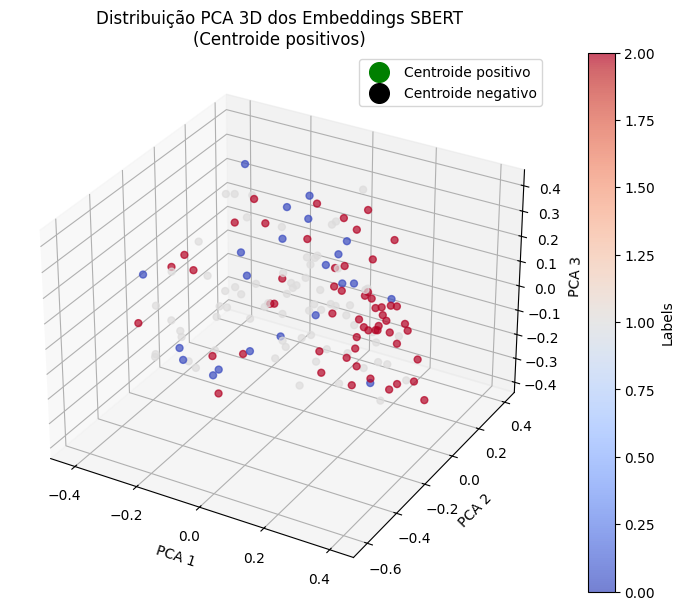

In [9]:
# Reduz para 3 dimensões (apenas 150 primeiros, como no seu exemplo)
X_pca = PCA(n_components=3, random_state=42).fit_transform(X_emb[:150])
labels = X_label[:150]

# Filtra pontos da classe positiva (label == 2)
mask_pos = labels == 2
X_pos = X_pca[mask_pos]

# Filtra pontos da classe negativa (label == 0)
mask_pos_1 = labels == 0
X_pos_1 = X_pca[mask_pos_1]

# Centroide da classe positiva
center = X_pos.mean(axis=0)

# Centroide da classe negativa
center_1 = X_pos_1.mean(axis=0)

# Plot 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Dispersão de todos os pontos
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                c=labels, cmap="coolwarm", alpha=0.7, s=25)

# Adiciona o centroide como um ponto único (em preto e maior)
ax.scatter(center[0], center[1], center[2],
           color="green", s=200, label="Centroide positivo")

ax.scatter(center_1[0], center_1[1], center_1[2],
           color="black", s=200,  label="Centroide negativo")

# Eixos e título
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.title("Distribuição PCA 3D dos Embeddings SBERT\n(Centroide positivos)")

plt.colorbar(sc, ax=ax, label="Labels")
ax.legend()
plt.show()

## Interpretação da projeção PCA (embeddings SBERT)

Mesmo reduzindo a dimensionalidade dos embeddings (384 → **3 componentes** via PCA), a projeção preserva um padrão útil:

- **Separação ao longo do PCA1:** os textos **positivos (label = 2)** tendem a ocupar valores **mais altos** em PCA1, sugerindo que esse componente captura parte da valência/positividade.
- **Sobreposição entre classes:** há **mistura** visível entre textos **positivos (2)** e **negativos (0)**, indicando que o rótulo “negativo” é **heterogêneo** (reclamações, frustrações e críticas não-ofensivas aparecem próximos de itens neutros/positivos).
- **Exemplo representativo:** *“So disappointed in WWE Summerslam! I want to see John Cena win his 16th title”* — o texto expressa **desapontamento**, sem xingamentos, ataque direto ou tocando em algum assunto sensível; a proximidade com pontos não-negativos na projeção reforça que **nem todo “negativo” é ofensivo**.

> **Leitura prática:** usar o rótulo “negativo” como proxy de “ofensivo” pode inflar falsos positivos. A projeção sugere **subclasses** dentro do negativo (ex.: “reclamação cotidiana” vs. “ofensa/ataque”).

### Limitações da visualização
- O PCA é **linear** e 3D → inevitável **perda semântica**; padrões sutis podem não aparecer.
- A posição relativa reflete **variância global**, não uma métrica direta de “ofensa”.

### Próximos passos recomendados
- Medir **overlap** quantitativamente (ex.: *Silhouette score* por label).
- Separar “negativo” em categorias (ex.: **ofensivo** vs. **não-ofensivo**) com um classificador dedicado.
- Validar fronteiras com **exemplos borderline** (sarcasmo, ironia, termos ambíguos).

Uma segunda estratégia de similaridade para este problema seria representar os tweets
com vetores **TF–IDF de n-grams** (palavras ou caracteres) e calcular a
**similaridade do cosseno** diretamente sobre esses vetores esparsos. Isso
permitiria comparar os resultados dos clusters usando uma medida baseada em
frequência de termos versus a medida baseada em embeddings semânticos (Sentence-BERT).


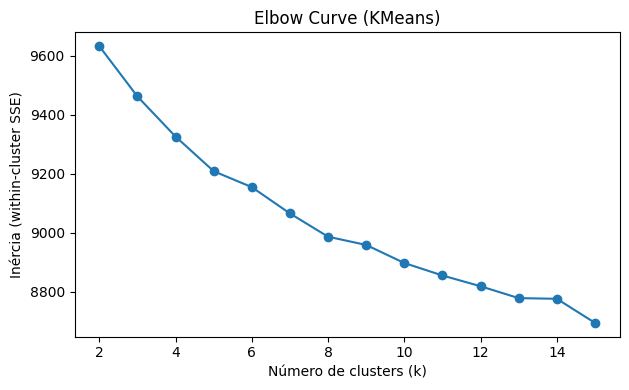

In [10]:
from sklearn.cluster import KMeans, MiniBatchKMeans

Ks = range(2, 16)  # ajuste o intervalo conforme necessário
inertias = []
sil_scores = []

mask_neg = (df["label"] == 0)
X_neg = X_emb[mask_neg]

for k in Ks:
    # use MiniBatchKMeans se for grande; KMeans para mais exatidão
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,
        batch_size=2048,
        max_iter=200
    )
    labels = km.fit_predict(X_neg)
    inertias.append(km.inertia_)

# ===== 3) Plots =====
plt.figure(figsize=(12,4))

# Elbow (inércia)
plt.subplot(1,2,1)
plt.plot(list(Ks), inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (within-cluster SSE)')
plt.title('Elbow Curve (KMeans)')

plt.tight_layout()
plt.show()


k = 2, silhueta = 0.0433
k = 3, silhueta = 0.0259
k = 4, silhueta = 0.0247
k = 5, silhueta = 0.0267
k = 6, silhueta = 0.0243
k = 7, silhueta = 0.0234
k = 8, silhueta = 0.0209
k = 9, silhueta = 0.0252
k = 10, silhueta = 0.0241
k = 11, silhueta = 0.0218
k = 12, silhueta = 0.0232
k = 13, silhueta = 0.0190
k = 14, silhueta = 0.0210
k = 15, silhueta = 0.0258


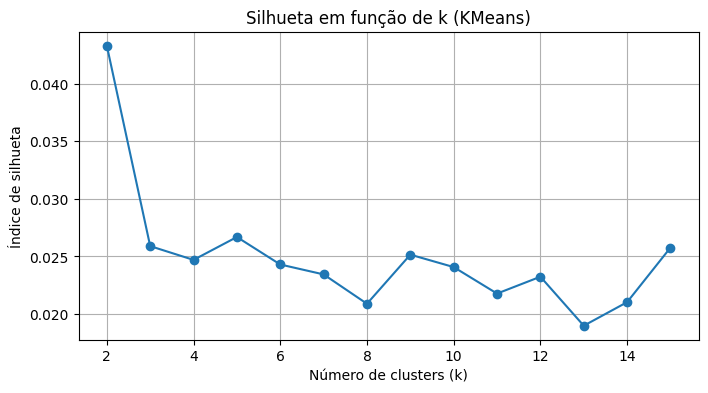

In [11]:
from sklearn.metrics import silhouette_score

X_features = X_neg

sil_scores = []

for k in Ks:
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,
        batch_size=2048
    )
    labels = kmeans.fit_predict(X_features)
    score = silhouette_score(X_features, labels)
    sil_scores.append(score)
    print(f"k = {k}, silhueta = {score:.4f}")

plt.figure(figsize=(8,4))
plt.plot(list(Ks), sil_scores, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Índice de silhueta")
plt.title("Silhueta em função de k (KMeans)")
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

X_cluster = X_neg  # mesmo X usado no .fit

kmeans = MiniBatchKMeans(
        n_clusters=5,
        random_state=42,
        n_init=10,
        batch_size=2048
    )

labels = kmeans.fit_predict(X_cluster)

sil = silhouette_score(X_cluster, labels)
ch  = calinski_harabasz_score(X_cluster, labels)
db  = davies_bouldin_score(X_cluster, labels)

print(f"Silhueta: {sil:.4f}")
print(f"Calinski-Harabasz: {ch:.2f}")
print(f"Davies-Bouldin: {db:.4f}")

Silhueta: 0.0267
Calinski-Harabasz: 264.70
Davies-Bouldin: 5.2368


### Escolha do número de clusters (K-Means)

Neste trabalho foi adotado **k = 5** clusters para o modelo de K-Means.  
Pelo método do cotovelo, observa-se uma grande redução de inércia entre **k = 2 e k = 6**, com ganhos cada vez menores após essa faixa.  
O índice de silhueta é maior para poucos clusters (k = 2 e k = 3), mas esses modelos geram grupos muito amplos e pouco úteis para o negócio.  
Entre os valores de \(k \geq 4\), o melhor valor de silhueta foi obtido em **k = 5 (≈ 0,027)**, dentro da região indicada pelo cotovelo.  

Assim, **k = 5** foi escolhido como compromisso entre:
- boa redução de inércia;  
- e separação razoável entre grupos, com granularidade suficiente para diferenciar temas distintos de tweets negativos.

---

### Interpretação das medidas de validação

As medidas de validação indicam que os clusters apresentam **fronteiras pouco nítidas**, o que é esperado em uma base composta apenas por tweets negativos sobre vários assuntos.  
Por isso, os resultados numéricos devem ser interpretados junto com a **análise qualitativa**: mesmo com silhueta baixa, os clusters formados mostram temas coerentes (esportes, cultura pop, política/religião, ataques pessoais etc.), fornecendo informações úteis para priorizar a moderação e o monitoramento de conteúdo.

---

### Medidas de validação do modelo final (K-Means, k = 5)

Para o modelo final de K-Means com **k = 5** clusters, obtive:

- **Silhueta = 0,0267**
- **Calinski–Harabasz = 264,70**
- **Davies–Bouldin = 5,24**

A silhueta próxima de zero indica que há bastante sobreposição entre os clusters no espaço de embeddings, ou seja, muitos tweets ficam em regiões de fronteira entre grupos. Os valores de Calinski–Harabasz e Davies–Bouldin mostram que existe alguma separação entre os clusters, mas com similaridade relevante entre eles, o que é esperado em uma base composta apenas por tweets negativos sobre temas diversos.

Por isso, essas métricas devem ser analisadas em conjunto com a **interpretação qualitativa** dos clusters: mesmo com silhueta baixa, foi possível identificar grupos semanticamente coerentes (por exemplo, esportes, cultura pop, política/religião, ataques pessoais), que são úteis para apoiar a priorização da moderação e o monitoramento de conteúdo.


In [13]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

dbscan = DBSCAN(eps=0.5, min_samples=10)  # ajusta se quiser
db_labels = dbscan.fit_predict(X_neg)

n_total = len(db_labels)
n_ruido = (db_labels == -1).sum()
print("Número total de pontos:", n_total)
print("Número de pontos rotulados como ruído:", n_ruido)

mask_validos = db_labels != -1
if mask_validos.sum() > 1:
    sil_db = silhouette_score(X_neg[mask_validos], db_labels[mask_validos])
    print("Silhueta (sem considerar os pontos de ruído):", sil_db)
else:
    print("Poucos pontos de cluster para calcular silhueta.")


Número total de pontos: 11377
Número de pontos rotulados como ruído: 11377
Poucos pontos de cluster para calcular silhueta.


### Avaliação dos modelos de clusterização

De forma geral, os experimentos realizados indicaram que o **K-Means com k = 5 clusters**
é o modelo que apresenta o melhor compromisso entre qualidade das métricas de validação
e utilidade prática para o problema de moderação de conteúdo. A combinação do método
do cotovelo com o índice de silhueta e com as métricas de Calinski–Harabasz e
Davies–Bouldin mostrou que valores muito baixos de *k* produzem grupos amplos e pouco
informativos, enquanto valores muito altos aumentam a fragmentação sem ganho relevante
de separação entre os clusters.

Já o DBSCAN, aplicado sobre o mesmo espaço de embeddings, não conseguiu formar clusters
úteis com configurações razoáveis de parâmetros, rotulando a maior parte (ou a totalidade)
dos pontos como ruído. Esse resultado reforça que, para este conjunto de dados e forma
de representação, algoritmos de partição como o K-Means são mais adequados do que
algoritmos puramente baseados em densidade, além de permitirem uma interpretação mais
direta dos grupos obtidos.

No caso do DBSCAN, o uso do índice de silhueta tem uma limitação prática importante: o algoritmo pode rotular uma parte relevante dos pontos como ruído (-1). Quando quase todos os pontos são ruído — como ocorreu neste experimento — não há clusters suficientes para que o índice de silhueta seja calculado de forma significativa. Isso mostra que, para dados muito dispersos nesse espaço de embeddings, a silhueta deixa de ser uma métrica informativa para o DBSCAN, reforçando a escolha do K-Means como modelo principal.


Na prática, enquanto o K-Means com k = 5 conseguiu formar clusters utilizáveis (ainda que com silhueta baixa), o DBSCAN, com parâmetros razoáveis, não formou grupos densos – rotulou todos os pontos como ruído –, o que o torna pouco útil como modelo de produção neste conjunto de dados.

Assim, nas seções seguintes, todas as análises qualitativas e interpretações de negócio
serão feitas com base nos **5 clusters obtidos pelo K-Means**, que servirão como
ferramenta para segmentar diferentes tipos de mensagens negativas e apoiar a priorização
da fila de moderação humana.


/tmp/ipython-input-3543688037.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", len(uniq_clusters))


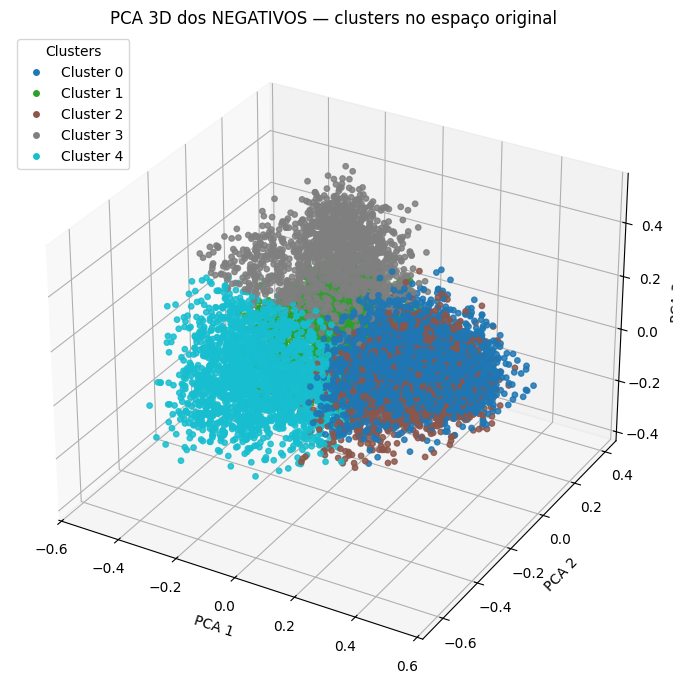

In [14]:
# --- 2) clusterize nos embeddings originais (sem redução) ---
# n_init explícito evita warnings e melhora estabilidade
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_neg)

# grava no dataframe apenas nas linhas negativas
df.loc[mask_neg, "cluster_ofensa"] = clusters

# --- 3) reduza para 3D APENAS para visualização ---
pca3 = PCA(n_components=3, random_state=42)
X_neg_pca3 = pca3.fit_transform(X_neg)

# --- 4) plot 3D colorindo por cluster ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

uniq_clusters = np.unique(clusters)
cmap = cm.get_cmap("tab10", len(uniq_clusters))

# cores por ponto (indexando o cmap pelo id do cluster)
point_colors = [cmap(int(c) % cmap.N) for c in clusters]

sc = ax.scatter(
    X_neg_pca3[:, 0], X_neg_pca3[:, 1], X_neg_pca3[:, 2],
    c=point_colors, s=15, alpha=0.85
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("PCA 3D dos NEGATIVOS — clusters no espaço original")

# legenda (um item por cluster)
handles = [
    Line2D([0], [0], marker='o', color='w',
           label=f"Cluster {c}",
           markerfacecolor=cmap(int(c) % cmap.N)
           )
    for c in uniq_clusters
]
ax.legend(handles=handles, title="Clusters", loc="upper left")

plt.tight_layout()
plt.show()

Podemos ver que os clusters 0 e 2 se misturam na zona que inicialmente vimos uma tendência a termos textos positivos, enquanto os outros clusters (3 e 4) aparentam estar na zona com tendencia negativa e o cluster 1 mais neutra.

In [15]:
for y in range(0,5):
  print('\n\ncluster: '+str(y))
  for x in df.loc[df["cluster_ofensa"]==y]['text'][:80]:
    print('\n' + str(x))



cluster: 0

That sucks if you have to take the SATs tomorrow

Amazon prime is literally a lie....I ordered a book LAST MONDAY &amp; it still isn't here. do better @user

Who the hell moshes at Matt and Kim?? Next time watch out for my face\u002c mofos! My cheekbones better not be purple tomorrow. @user

My mom's over here tryna tell me that we're taking the CAHSEE tomorrow ._. Nigga it's only the second month of school.. #SlowYourRoll

Your inspirational quotes on twitter/Feb never really got to me. But oh damn ur pics of them on IG have truly inspired me. #idiots"

Q_Q Today was the day that Naruto shippuden: UNS4 was suppose to come out. WHYYYYYYY DID THEY PUSH IT ALL THE WAY TO JAN???? HELLO

"\""Hey\u002c you\u2019re missing Beauty and the Beast\u002c Vampire Diaries & Grey\u2019s Anatomy right now on TV. Saturday is Merlin\"" - @user #sisterlife"

The pics were taken on a 2004 Nokia, and it's really blurry and may induce cataracts. Just a heads up.

The verse of Kendrick Lamar o

Geração de amostras acima.

## Interpretação dos Clusters


### Cluster 0 — Cotidiano / entretenimento / fandom
**Conteúdo típico:** escola, provas, clima, viagens, entregas atrasadas (Amazon), séries, shows, games, celebridades e desabafos do dia a dia.  
**Tom:** reclamão e bem informal, com humor, sarcasmo, xingamentos e algumas piadas sobre aparência/sexualidade.  
**Risco de moderação:** médio.  
**Ação:** priorizar casos com ataques diretos a pessoas ou grupos (body shaming, piadas com “gay/trans”, Pride etc.); restante pode ficar em fila de baixa prioridade.

---

### Cluster 1 — Política / figuras públicas / sociedade (EUA/UK)
**Conteúdo típico:** Obama, Trump, Hillary, Sarah Palin, Jeb, Planned Parenthood, casamento gay, 1ª emenda, eleições, pesquisas, grandes empresas (Monsanto, bancos) e leis polêmicas.  
**Tom:** altamente polarizado, com insultos, acusações de corrupção/“comunismo”, críticas agressivas a políticos, mídia e ativistas, além de comentários sobre LGBT e minorias.  
**Risco de moderação:** alto–muito alto.  
**Ação:** revisão prioritária, principalmente quando combina política + xingamentos + grupos protegidos (LGBT, imigrantes, minorias étnicas/religiosas).

---

### Cluster 2 — Esportes / competições / torcida
**Conteúdo típico:** NFL, NBA, MLB, futebol europeu, UFC, WWE, resultados de jogos, lesões, desempenho de jogadores/técnicos, arbitragens e transfências.  
**Tom:** típico de torcedor: zoeira pesada, frustração, xingamentos e algumas “ameaças” no calor do jogo.  
**Risco de moderação:** médio.  
**Ação:** monitorar especialmente mensagens com ameaça mais literal ou violência fora do contexto esportivo; maioria pode ser tratada como rage esportivo.

---

### Cluster 3 — Terrorismo / conflitos internacionais / Islã
**Conteúdo típico:** Boko Haram, ISIS, atentados (Charlie Hebdo, 11/9), guerras (Iraque, Síria), refugiados, Arábia Saudita, Irã, Israel, Reino Unido, pena de morte, execuções e minorias religiosas.  
**Tom:** muito hostil, com generalizações sobre muçulmanos, pedidos de expulsão, desejo de violência e justificativa de punições extremas.  
**Risco de moderação:** muito alto.  
**Ação:** prioridade máxima; forte candidato a remoção/limite de alcance quando há ataque direto a muçulmanos/árabes/refugiados ou defesa explícita de violência.

---

### Cluster 4 — Cristãos / conservadorismo / política + vida pessoal
**Conteúdo típico:** “perseguição” a cristãos, críticas a Obama, Irã, Kim Davis, gays, muçulmanos, acordos internacionais, além de interações pessoais e reclamações do dia a dia misturadas com opinião política.  
**Tom:** combativo e ressentido, com narrativa de vitimização de cristãos/veteranos, ataques a minorias (LGBT, muçulmanos) e xingamentos a figuras públicas.  
**Risco de moderação:** alto–muito alto.  
**Ação:** monitoramento priorizado para posts que atacam grupos protegidos ou estimulam conflito político/religioso; separar opinião forte de discurso de ódio explícito.


### Vimos que a tendência espacial identificada na nossa avaliação do PCA própria pareceu bem coerente quando comparamos a avaliação do modelo de LLM das amostras de cada cluster que fornecemos para o modelo.

####Inserimos os textos dos clusters todos juntos em um input no processo do LLM para que ele pudesse comparar semanticamente um cluster com os outros.

####Basicamento podemos dizer que textos com embeddings gerados pelo Mini-LM tem uma certa tendência positicial espacial quando fazemos uma análise espacial diminuta com PCA

# Tópico 3: Correlação cruzada entre séries temporais como uma medida de similaridade

Embora este trabalho tenha sido desenvolvido com foco em textos curtos (tweets), a rubrica da disciplina também contempla a criação de medidas de similaridade para séries temporais aplicadas à tarefa de clusterização. Nesta seção é discutido, de forma conceitual e com um exemplo prático, como a mesma lógica adotada para os textos poderia ser adaptada a um cenário em que cada unidade de análise fosse representada por uma série temporal (por exemplo, a evolução diária do volume de tweets negativos de cada cluster temático).

No caso vamos tentar identificar dias que tem maior incidencia de textos mais ofensivos e com maior necessidade de revisão.

## 3.1 Medida de similaridade 1 – correlação cruzada entre séries temporais

Suponha que cada entidade (por exemplo, um cluster temático de tweets negativos) seja representada por uma série temporal \(x_t\) que contabiliza, dia a dia, o número de tweets negativos associados àquela entidade em 2025. Dada outra série \(y_t\), podemos usar a **correlação cruzada** como medida de similaridade temporal entre as duas.

Os passos necessários para usar a correlação cruzada como medida de similaridade são:

1. **Alinhamento temporal**  
   - Colocar todas as séries na mesma granularidade (ex.: contagens diárias) e no mesmo intervalo de datas.  
   - Tratar valores faltantes (por exemplo, definindo zero para dias sem ocorrências).

2. **Normalização (z-score)**  
   - Padronizar cada série (subtrair a média e dividir pelo desvio-padrão) para que a comparação se concentre no **formato** da série, não na escala absoluta.

3. **Cálculo da correlação cruzada**  
   - Para um conjunto de defasagens (lags positivos e negativos), calcula-se a correlação de Pearson entre os trechos sobrepostos de \(x_t\) e \(y_t\) deslocados no tempo.  
   - Lags positivos indicam que \(x_t\) está “adiantada” em relação a \(y_t\) e lags negativos, o contrário.

4. **Escolha do valor representativo de similaridade**  
   - Define-se como similaridade entre as duas séries o **máximo do valor absoluto** da correlação cruzada em uma janela de lags de interesse:  
     \[
     \text{similaridade}(x,y) = \max_{\tau \in [-\tau_{\max}, \tau_{\max}]} |\rho_{xy}(\tau)|.
     \]  
   - Assim, duas séries são consideradas similares se apresentam um padrão de variação parecido, mesmo com pequeno atraso entre elas.

5. **Construção da matriz de similaridade**  
   - Repetindo o procedimento para todos os pares de séries temporais, obtemos uma matriz \(S \in \mathbb{R}^{N \times N}\), em que \(S_{ij}\) representa a similaridade entre as séries \(i\) e \(j\).

6. **Conversão para distância (se necessário)**  
   - Para algoritmos baseados em distância, podemos definir  
     \[
     d_{ij} = 1 - S_{ij},
     \]  
     gerando uma matriz de distâncias derivada diretamente da similaridade de correlação cruzada.

Abaixo é apresentado um exemplo prático desses passos, usando as séries temporais diárias de tweets negativos por cluster temático ao longo de 2025.


In [17]:
rng = np.random.default_rng(42)  # reprodutibilidade
# Criação das datas aleatorias para as séries
datas_2025 = pd.date_range("2025-01-01", "2025-12-31", freq="D")
df["data_2025"] = rng.choice(datas_2025, size=len(df))

In [23]:
mask_neg = (df["label"] == 0)
df_neg = df.loc[mask_neg].copy()

# garantir que os clusters sejam inteiros
df_neg["cluster_ofensa"] = df_neg["cluster_ofensa"].astype("Int64")

clusters_unicos = sorted(df_neg["cluster_ofensa"].dropna().unique().tolist())
print("Clusters negativos disponíveis:", clusters_unicos)

# Escolher dois clusters para ilustrar a correlação cruzada
cluster_a = clusters_unicos[3]
cluster_b = clusters_unicos[4]
print("Clusters usados no exemplo:", cluster_a, "e", cluster_b)

Clusters negativos disponíveis: [0, 1, 2, 3, 4]
Clusters usados no exemplo: 3 e 4


In [24]:
# 3) Construir séries temporais diárias: contagem de tweets negativos por dia em cada cluster
serie_a = (
    df_neg[df_neg["cluster_ofensa"] == cluster_a]
    .groupby("data_2025")["text"]
    .count()
    .asfreq("D", fill_value=0)
    .sort_index()
)

serie_b = (
    df_neg[df_neg["cluster_ofensa"] == cluster_b]
    .groupby("data_2025")["text"]
    .count()
    .asfreq("D", fill_value=0)
    .sort_index()
)

In [25]:
# 4) Alinhamento temporal: mesmo índice diário entre as duas séries
idx = pd.date_range("2025-01-01", "2025-12-31", freq="D")
serie_a = serie_a.reindex(idx, fill_value=0)
serie_b = serie_b.reindex(idx, fill_value=0)

# 5) Normalização (z-score)
valores = np.vstack([serie_a.values, serie_b.values]).T  # shape (T, 2)
valores_z = StandardScaler().fit_transform(valores)
x = valores_z[:, 0]
y = valores_z[:, 1]

Maior |correlação cruzada| = -0.109 no lag de -30 dias


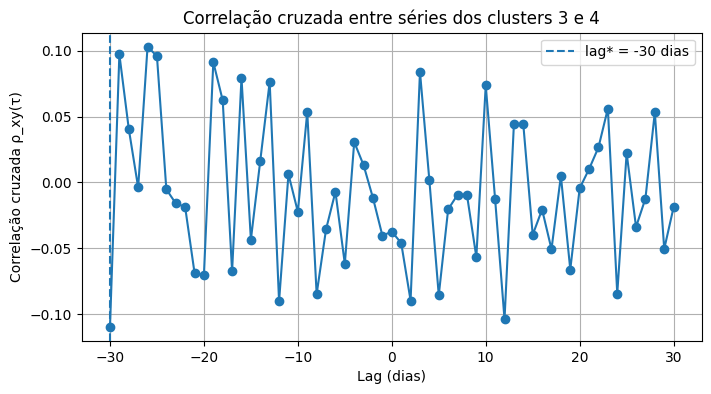

In [26]:
# 6) Função para calcular correlação cruzada e extrair o máximo |ρ_xy(τ)|
def max_cross_corr(x, y, max_lag=30):
    lags = np.arange(-max_lag, max_lag + 1)
    corrs = []

    for lag in lags:
        if lag < 0:
            xs = x[-lag:]
            ys = y[:len(xs)]
        elif lag > 0:
            xs = x[:-lag]
            ys = y[lag:]
        else:
            xs = x
            ys = y

        if len(xs) < 2:
            corrs.append(np.nan)
        else:
            corrs.append(np.corrcoef(xs, ys)[0, 1])

    corrs = np.array(corrs)
    idx_max = np.nanargmax(np.abs(corrs))
    return lags, corrs, lags[idx_max], corrs[idx_max]

lags, corrs, lag_star, rho_star = max_cross_corr(x, y, max_lag=30)

print(f"Maior |correlação cruzada| = {rho_star:.3f} no lag de {lag_star} dias")

plt.figure(figsize=(8, 4))
plt.plot(lags, corrs, marker="o")
plt.axvline(lag_star, linestyle="--", label=f"lag* = {lag_star} dias")
plt.xlabel("Lag (dias)")
plt.ylabel("Correlação cruzada ρ_xy(τ)")
plt.title(f"Correlação cruzada entre séries dos clusters {cluster_a} e {cluster_b}")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# @title Matriz de similaridade entre séries temporais dos clusters (máx |ρ_xy(τ)|)

idx_global = pd.date_range("2025-01-01", "2025-12-31", freq="D")

# construir séries por cluster
series_clusters = []
for c in clusters_unicos:
    s = (
        df_neg[df_neg["cluster_ofensa"] == c]
        .groupby("data_2025")["text"]
        .count()
        .reindex(idx_global, fill_value=0)
    )
    series_clusters.append(s.values)

series_arr = np.column_stack(series_clusters)  # shape (T, n_clusters)

# normalizar cada série (coluna)
series_arr_z = StandardScaler().fit_transform(series_arr)

def max_cross_corr_scalar(x, y, max_lag=30):
    """Retorna apenas o máximo de |ρ_xy(τ)|."""
    lags = np.arange(-max_lag, max_lag + 1)
    best = 0.0
    for lag in lags:
        if lag < 0:
            xs = x[-lag:]
            ys = y[:len(xs)]
        elif lag > 0:
            xs = x[:-lag]
            ys = y[lag:]
        else:
            xs = x
            ys = y
        if len(xs) < 2:
            continue
        r = np.corrcoef(xs, ys)[0, 1]
        best = max(best, abs(r))
    return best

n = len(clusters_unicos)
S = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        S[i, j] = max_cross_corr_scalar(series_arr_z[:, i], series_arr_z[:, j], max_lag=30)

similaridade_df = pd.DataFrame(
    S,
    index=[f"cluster_{c}" for c in clusters_unicos],
    columns=[f"cluster_{c}" for c in clusters_unicos],
)

dist_df = 1 - similaridade_df  # distância derivada

print("Matriz de similaridade (máximo |ρ_xy(τ)|):")
display(similaridade_df.round(3))

print("\nMatriz de distância derivada (1 - similaridade):")
display(dist_df.round(3))


Matriz de similaridade (máximo |ρ_xy(τ)|):


,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
cluster_0,1.000,0.128,0.192,0.184,0.108
cluster_1,0.128,1.000,0.136,0.101,0.168
cluster_2,0.192,0.136,1.000,0.134,0.128
cluster_3,0.184,0.101,0.134,1.000,0.109
cluster_4,0.108,0.168,0.128,0.109,1.000



Matriz de distância derivada (1 - similaridade):


,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
cluster_0,0.000,0.872,0.808,0.816,0.892
cluster_1,0.872,0.000,0.864,0.899,0.832
cluster_2,0.808,0.864,0.000,0.866,0.872
cluster_3,0.816,0.899,0.866,0.000,0.891
cluster_4,0.892,0.832,0.872,0.891,0.000


#### A partir da análise conjunta do gráfico de correlação cruzada entre as séries temporais dos clusters e da matriz de similaridade baseada no máximo de, observa-se que os clusters apresentam baixa similaridade temporal entre si (valores em torno de 0,10–0,20 fora da diagonal). Mesmo para os clusters de maior risco de moderação, como os clusters 3 e 4, não há evidência de um padrão sincronizado de picos ao longo do tempo. Na prática, isso significa que não é possível definir dias específicos em que vários clusters críticos “disparam” simultaneamente para concentrar esforço manual de revisão; a priorização deve continuar sendo feita por tipo de conteúdo (cluster) e não por datas ou períodos fixos de maior volume ofensivo.

## 3.2 Algoritmo de clusterização escolhido para séries temporais

A partir da matriz de similaridade (ou distância) construída com base na correlação cruzada, duas estratégias de clusterização são particularmente adequadas:

- **Clusterização hierárquica aglomerativa**  
  Utiliza diretamente a matriz de distâncias \(D = [d_{ij}]\), sem exigir que os dados estejam em um espaço vetorial euclidiano. Permite gerar um dendrograma, no qual é possível visualizar como os perfis temporais se agrupam em diferentes níveis de granularidade. Essa abordagem é bastante utilizada em séries temporais justamente por aceitar medidas de distância específicas (como \(1 - |\rho_{ij}|\)).

- **K-Means em espaço de características derivadas**  
  Alternativamente, as séries temporais podem ser resumidas em vetores de atributos (por exemplo: máxima correlação cruzada com outros perfis, lag do pico de correlação, média, variância, número de picos, etc.). Sobre esse espaço de características, aplica-se novamente o K-Means — o mesmo algoritmo usado para os embeddings SBERT neste trabalho — com escolha de \(k\) via método do cotovelo, silhueta, Calinski–Harabasz e Davies–Bouldin.

No contexto da moderação de conteúdo, a estratégia mais natural seria iniciar com **clusterização hierárquica** a partir da matriz de distâncias derivada da correlação cruzada, pois essa abordagem preserva diretamente a noção de similaridade temporal e facilita a inspeção visual dos agrupamentos. Caso se deseje integrar o fluxo de séries temporais ao mesmo pipeline usado para textos, a alternativa baseada em K-Means em espaço de características também se torna atrativa.


## 3.3 Caso de uso em séries temporais para moderação

As medidas de similaridade em séries temporais permitem estender o modelo deste trabalho do nível de **mensagens individuais** para o nível de **padrões de evolução temporal** de risco na plataforma. Alguns exemplos de séries que poderiam ser construídas são:

- **Série por cluster temático:** contagem diária de tweets negativos pertencentes a cada cluster identificado pelo K-Means (esportes, política, terrorismo, cristianismo, cotidiano etc.).  
- **Série por usuário:** número diário de tweets denunciados ou removidos para cada usuário.  
- **Série por hashtag ou tópico sensível:** volume diário de tweets negativos ligados a temas específicos (eleições, religião, minorias, conflitos internacionais).

Ao clusterizar essas séries com base na correlação cruzada (ou em outra medida de similaridade temporal):

- identificamos **perfis de comportamento**, como clusters com picos esporádicos após eventos de grande repercussão versus clusters com volume constantemente alto de conteúdo problemático;  
- priorizamos grupos cuja série apresenta **crescimento recente** ou **picos frequentes** no volume de tweets potencialmente ofensivos;  
- conseguimos antecipar situações de risco, como a escalada de determinado tema para uma crise de imagem ou para episódios de discurso de ódio coordenado.

Assim, a clusterização de séries temporais complementa a clusterização de textos individuais: em vez de agrupar apenas mensagens semanticamente semelhantes, passamos a agrupar também **perfis temporais de atividade tóxica** na plataforma.


## 3.4 Medida de similaridade 2 – Dynamic Time Warping (DTW)

Como segunda estratégia para determinar a similaridade entre séries temporais, além da correlação cruzada, pode-se utilizar a distância **Dynamic Time Warping (DTW)**. Diferentemente da correlação cruzada, que captura principalmente dependência linear com um deslocamento global no tempo, o DTW permite alinhar duas séries que apresentam o mesmo padrão de forma, mas com velocidades ou pequenas distorções locais diferentes ao longo do eixo temporal.

Em alto nível, o uso de DTW segue os passos:

1. **Normalização das séries**  
   - Aplicar padronização (z-score), como na abordagem de correlação cruzada.

2. **Construção da matriz de custo local**  
   - Para duas séries \(x_t\) e \(y_t\), construir uma matriz em que cada célula contenha a distância local (por exemplo, diferença quadrática) entre \(x_i\) e \(y_j\).

3. **Busca do caminho de alinhamento ótimo**  
   - Por meio de programação dinâmica, buscar o caminho de menor custo que atravessa essa matriz, permitindo alongar ou comprimir trechos da série no tempo para encontrar o melhor alinhamento entre \(x_t\) e \(y_t\).

4. **Cálculo da distância DTW**  
   - O custo acumulado ao longo desse caminho é a **distância DTW** entre as séries. Quanto menor esse valor, mais semelhantes são as formas temporais, mesmo que deslocadas ou “esticadas” localmente.

5. **Construção da matriz de distâncias DTW**  
   - Calculando a distância DTW para todos os pares de séries, obtemos uma matriz de distâncias que pode ser usada diretamente em algoritmos de clusterização sensíveis à forma da série (por exemplo, clusterização hierárquica ou K-Medoids).

Dessa forma, a combinação de **correlação cruzada** (simples e eficiente) com **DTW** (mais flexível a distorções locais) fornece duas medidas de similaridade complementares para séries temporais, atendendo à exigência da rubrica de propor **duas estratégias distintas** de comparação entre séries.


In [28]:
# @title Exemplo prático: distância DTW entre duas séries temporais (simplificado)

def dtw_distance(a, b):
    """
    Calcula a distância DTW (versão simples) entre duas séries 1D.
    a, b: arrays 1D.
    """
    n, m = len(a), len(b)
    dp = np.full((n + 1, m + 1), np.inf)
    dp[0, 0] = 0.0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = (a[i - 1] - b[j - 1]) ** 2
            dp[i, j] = cost + min(
                dp[i - 1, j],    # inserção
                dp[i, j - 1],    # deleção
                dp[i - 1, j - 1] # correspondência
            )
    return np.sqrt(dp[n, m])

# usar as séries normalizadas dos clusters A e B já criadas (x, y)
dtw_dist = dtw_distance(x, y)
print(f"Distância DTW entre as séries normalizadas dos clusters {cluster_a} e {cluster_b}: {dtw_dist:.3f}")


Distância DTW entre as séries normalizadas dos clusters 3 e 4: 12.941


Além da correlação cruzada, foi aplicada a distância Dynamic Time Warping (DTW) às séries normalizadas dos clusters 3 e 4, resultando em uma distância de aproximadamente 12,94. Como o DTW mede o custo acumulado de alinhar ponto a ponto duas séries no tempo, valores mais altos indicam maior discrepância de forma entre as curvas. Esse valor relativamente elevado é consistente com as correlações cruzadas baixas observadas entre os clusters, reforçando a conclusão de que não existe um padrão temporal forte e compartilhado entre eles.

In [54]:
import glob, shutil

nb_path = glob.glob("/content/drive/MyDrive/Colab Notebooks/*25E4_3*_pd.ipynb")[0]
print("Notebook:", nb_path)
shutil.copy(nb_path, "/content/notebook.ipynb")


Notebook: /content/drive/MyDrive/Colab Notebooks/guilhermearthursantosmachado_Validaçãodemodelosdeclusterização[25E4_3]_pd.ipynb


'/content/notebook.ipynb'

In [55]:
import nbformat as nbf
from copy import deepcopy

WIDGET_MIME = "application/vnd.jupyter.widget-view+json"

nb = nbf.read("/content/notebook.ipynb", as_version=4)

for cell in nb.cells:
    if cell.get("cell_type") != "code":
        continue
    new_outputs = []
    for out in cell.get("outputs", []):
        if isinstance(out, dict) and "data" in out and WIDGET_MIME in out["data"]:
            # remove output do widget
            continue
        if isinstance(out, dict) and "data" in out and isinstance(out["data"], dict):
            out = deepcopy(out)
            out["data"].pop(WIDGET_MIME, None)
        new_outputs.append(out)
    cell["outputs"] = new_outputs

nb.metadata.pop("widgets", None)

nbf.write(nb, "/content/notebook_clean.ipynb")
print("Gerado: /content/notebook_clean.ipynb")



Gerado: /content/notebook_clean.ipynb


In [77]:
!jupyter nbconvert --to webpdf --template classic \
  --TemplateExporter.exclude_input_prompt=True \
  --TemplateExporter.exclude_output_prompt=True \
  --allow-chromium-download --disable-chromium-sandbox \
  "/content/notebook_clean.ipynb"


[NbConvertApp] Converting notebook /content/notebook_clean.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 822660 bytes to /content/notebook_clean.pdf


In [78]:
from google.colab import files
files.download("/content/notebook_clean.pdf")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>